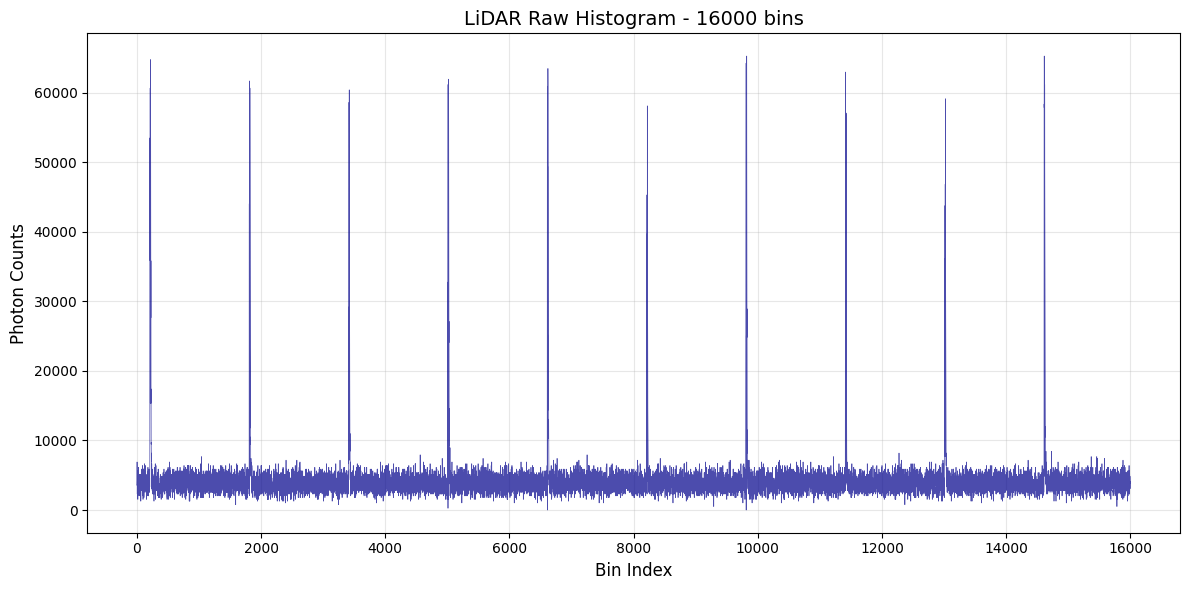

Total bins: 16000
Count range: 3 - 65282
Mean count: 4197.93
Peak bin: 14613 with count 65282


In [23]:
import numpy as np
import matplotlib.pyplot as plt

log_file = "data/raw_data_20251120_212543_dist130.log"

# Parse the log file
photon_counts = []

with open(log_file, "r") as f:
    for line in f:
        # Extract the DATA section
        if "DATA:" in line:
            data_part = line.split("DATA:")[1].strip()
            # Split hex bytes
            hex_bytes = data_part.split()

            # Convert pairs of hex bytes to 16-bit values (little-endian)
            for i in range(0, len(hex_bytes), 2):
                if i + 1 < len(hex_bytes):
                    low_byte = int(hex_bytes[i], 16)
                    high_byte = int(hex_bytes[i + 1], 16)
                    count = low_byte | (high_byte << 8)
                    photon_counts.append(count)

photon_counts = np.array(photon_counts)

# Create histogram plot
plt.figure(figsize=(12, 6))
plt.plot(photon_counts, linewidth=0.5, color="darkblue", alpha=0.7)
plt.xlabel("Bin Index", fontsize=12)
plt.ylabel("Photon Counts", fontsize=12)
plt.title(f"LiDAR Raw Histogram - {len(photon_counts)} bins", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.show()
plt.savefig(log_file.replace(".log", ".png"))

print(f"Total bins: {len(photon_counts)}")
print(f"Count range: {photon_counts.min()} - {photon_counts.max()}")
print(f"Mean count: {photon_counts.mean():.2f}")

print(f"Peak bin: {photon_counts.argmax()} with count {photon_counts.max()}")

In [27]:
peak_indices = []

# Gradient-Based
# BIAS = 2
# GRAD_TH = 5 * photon_counts.mean()
# for idx, pc in enumerate(photon_counts):
#     if idx == 0:
#         continue
#     gradient = pc - photon_counts[idx - 1]
#     if gradient > GRAD_TH:
#         peak_indices.append(idx)


# Sliding Window Max
BIAS = 2.11
SW_SIZE = 1600
intervals = []
for sw_idx in range(photon_counts.size // SW_SIZE):
    peak_indices.append(
        photon_counts[sw_idx * SW_SIZE : (sw_idx + 1) * SW_SIZE].argmax()
        + sw_idx * SW_SIZE
    )
    if sw_idx > 0:
        intervals.append(peak_indices[-1] - peak_indices[-2])

print(f"Avg Inter-Peak bins: {np.mean(intervals):.2f}")

print(peak_indices)

# Calculate distance using first peak
if peak_indices:
    first_peak_bin = peak_indices[0]
    bin_resolution_ps = 104.17  # picoseconds per bin
    speed_of_light = 299792458  # meters per second

    # Convert bin index to time (ps to seconds)
    time_of_flight_s = first_peak_bin * bin_resolution_ps * 1e-12

    # Distance = (speed of light * time of flight) / 2
    # Divide by 2 because light travels to target and back
    distance_m = (speed_of_light * time_of_flight_s) / 2 - BIAS

    print(f"\nFirst peak at bin: {first_peak_bin}")
    print(f"Time of flight: {time_of_flight_s * 1e9:.2f} ns")
    print(f"Distance: {distance_m:.2f} m")


Avg Inter-Peak bins: 1599.11
[np.int64(221), np.int64(1813), np.int64(3421), np.int64(5017), np.int64(6620), np.int64(8221), np.int64(9821), np.int64(11412), np.int64(13021), np.int64(14613)]

First peak at bin: 221
Time of flight: 23.02 ns
Distance: 1.34 m


## Simulation


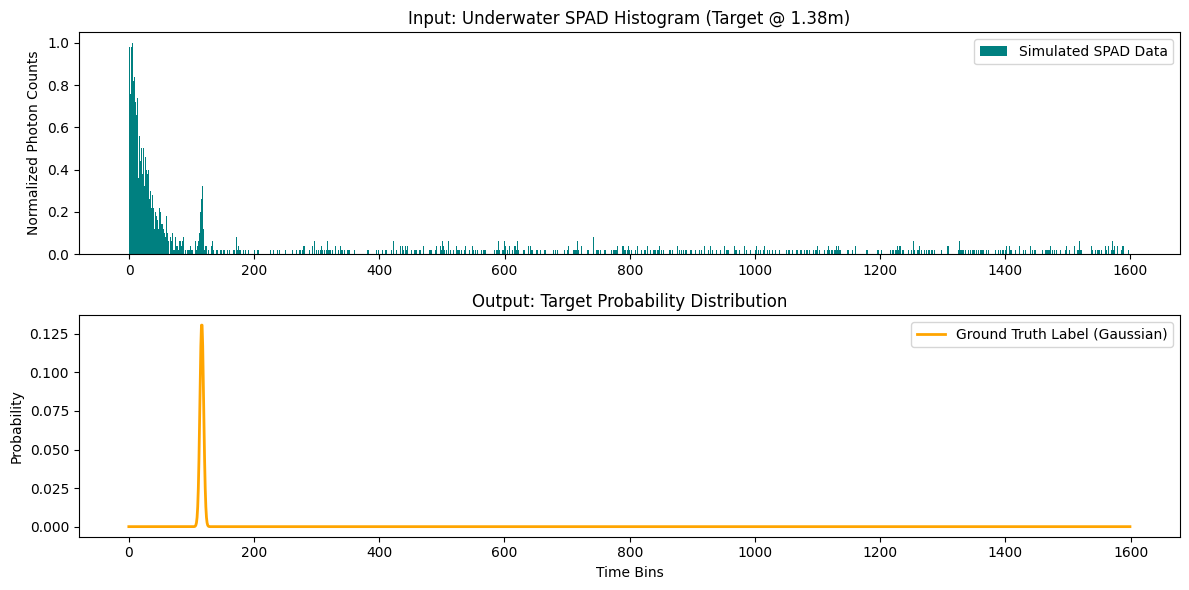

Generated sample with target at 1.38m
Expected Signal Photons: 72.66
Note the heavy backscatter peak on the left of the input histogram.


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf


class UnderwaterSPADSimulator:
    def __init__(
        self, bin_resolution_ps=104.17, lidar_period_bins=1600, laser_pulse_fwhm_ps=600
    ):
        """
        Initializes the simulator with SPAD hardware constraints.

        Args:
            bin_resolution_ps: Time resolution of one bin in picoseconds.
            lidar_period_bins: Total number of bins in the histogram.
            laser_pulse_fwhm_ps: Laser pulse width (Full Width Half Max).
        """
        # Hardware Parameters
        self.bin_res = bin_resolution_ps * 1e-12  # Convert to seconds
        self.num_bins = int(lidar_period_bins)
        self.period_duration = self.num_bins * self.bin_res

        # Optical Parameters (Based on PDF Table 1 & 2 logic)
        self.c_vacuum = 3e8
        self.refractive_index_water = 1.33
        self.c_water = self.c_vacuum / self.refractive_index_water

        # Laser Pulse Shape
        # Sigma derived from FWHM: sigma = FWHM / (2 * sqrt(2 * ln(2)))
        self.sigma_pulse = (laser_pulse_fwhm_ps * 1e-12) / (2 * np.sqrt(2 * np.log(2)))

        # Pre-compute time axis for efficiency
        self.time_axis = np.linspace(0, self.period_duration, self.num_bins)
        # Distance axis (for reference)
        self.dist_axis = 0.5 * self.c_water * self.time_axis

    def compute_bin_probabilities(self, mu_t, sigma_total, signal_photons):
        """
        Implements Eq. 7 from the PDF:
        Integrates the Gaussian PDF over the bin duration to get exact bin probability.

        Args:
            mu_t: Time of flight (center of the peak) in seconds.
            sigma_total: Total system jitter + pulse width (sigma).
            signal_photons: Average number of photons expected in this pulse (P_pp).
        """
        # Bin edges
        t_start = self.time_axis
        t_end = self.time_axis + self.bin_res

        # CDF calculation using Error Function (Eq 7 logic)
        # P(bin) = P_pp/2 * [erf((t_end - mu)/sig*sqrt(2)) - erf((t_start - mu)/sig*sqrt(2))]
        denom = sigma_total * np.sqrt(2)
        prob_dist = 0.5 * (erf((t_end - mu_t) / denom) - erf((t_start - mu_t) / denom))

        return prob_dist * signal_photons

    def generate_sample(
        self, target_bin_index=None, turbidity_level="medium", signal_strength="random"
    ):
        """
        Generates a single training pair: (Noisy Histogram, Ground Truth Gaussian).

        Args:
            target_bin_index: If None, picks random depth.
            turbidity_level: 'low', 'medium', 'high' (Controls backscatter/attenuation).
            signal_strength: 'random' or specific photon count float.

        Returns:
            noisy_histogram: The input for the U-Net (1D array).
            clean_target: The Ground Truth Gaussian PDF (1D array).
            metadata: Dict containing SNR, depth, etc.
        """

        # 1. Define Environmental Parameters based on Turbidity
        if turbidity_level == "low":  # Clear water
            attenuation_c = 0.1  # 1/m
            backscatter_amp = 10
            backscatter_decay = 2.0
        elif turbidity_level == "medium":  # Coastal water
            attenuation_c = 0.5
            backscatter_amp = 50
            backscatter_decay = 4.0
        else:  # Turbid/Harbor
            attenuation_c = 1.5
            backscatter_amp = 100
            backscatter_decay = 6.0

        # 2. Determine Target Depth (Ground Truth)
        if target_bin_index is None:
            target_bin_index = np.random.randint(10, self.num_bins / 10)

        target_time = self.time_axis[target_bin_index]
        target_dist = self.dist_axis[target_bin_index]

        # 3. Calculate Signal Return Strength (P_pp in Eq 1)
        # Apply Beer-Lambert Law: exp(-2 * c * R)
        # And inverse square law: 1 / R^2 (clamped to avoid div by zero)
        geometric_loss = 1.0 / (max(target_dist, 0.5) ** 2)
        transmission_loss = np.exp(-2 * attenuation_c * target_dist)

        if signal_strength == "random":
            base_reflectivity = np.random.uniform(10, 1000)
        else:
            base_reflectivity = signal_strength

        avg_signal_photons = base_reflectivity * geometric_loss * transmission_loss

        # 4. Generate Signal Component (The Target Peak)
        # PDF Eq 7: Gaussian spread over bins
        signal_profile = self.compute_bin_probabilities(
            target_time, self.sigma_pulse, avg_signal_photons
        )

        # 5. Generate Backscatter Component (The "Fog")
        # Model: A_bsc * exp(-k * t) / (t^2 offset) - simplified to exponential for 1D
        # Note: In real SPADs, backscatter saturates early bins.
        backscatter_profile = backscatter_amp * np.exp(
            -backscatter_decay * self.time_axis * 1e8
        )  # scaling time for decay

        # 6. Generate Ambient Noise (DC + Background - Eq 3)
        ambient_level = np.random.uniform(0.1, 2.0)  # Random solar/dark noise floor
        noise_floor = np.full(self.num_bins, ambient_level)

        # 7. Combine to get Rate Function (Lambda)
        # lambda(t) = Signal(t) + Backscatter(t) + Noise
        total_rate_function = signal_profile + backscatter_profile + noise_floor

        # 8. Simulate Photon Detection (Poisson Process)
        # In a real SPAD, we accumulate over N frames.
        # We simulate N frames simply by treating the rate as the mean of a Poisson distribution.
        # If N_frames is high, Poisson is accurate.
        noisy_histogram = np.random.poisson(total_rate_function)

        # 9. Generate Ground Truth Label (Soft Gaussian)
        # For the U-Net, we want a clean probability distribution, not a scalar distance.
        # We generate a normalized Gaussian centered at the true bin.
        # We use a fixed "ideal" sigma for the label (e.g., 2-3 bins wide) to help the network learn.
        label_sigma = 3 * self.bin_res
        ground_truth_profile = self.compute_bin_probabilities(
            target_time, label_sigma, 1.0
        )

        # Normalize Ground Truth to sum to 1 (probability distribution)
        if np.sum(ground_truth_profile) > 0:
            ground_truth_profile /= np.sum(ground_truth_profile)

        # Normalize Input Histogram (Standard practice for Neural Networks)
        # We usually max-normalize or standardize. Max-norm is safer for histograms.
        max_val = np.max(noisy_histogram)
        if max_val > 0:
            norm_input = noisy_histogram / max_val
        else:
            norm_input = noisy_histogram

        metadata = {
            "target_dist_m": target_dist,
            "signal_photons": avg_signal_photons,
            "total_counts": np.sum(noisy_histogram),
            "turbidity": turbidity_level,
        }

        return norm_input, ground_truth_profile, metadata


# ==========================================
# Example Usage & Visualization
# ==========================================

if __name__ == "__main__":
    sim = UnderwaterSPADSimulator(bin_resolution_ps=104.17, lidar_period_bins=1600)

    # Generate a few samples to verify
    input_hist, gt_label, meta = sim.generate_sample(turbidity_level="medium")

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot 1: Noisy Input (What the SPAD sees)
    plt.subplot(2, 1, 1)
    plt.bar(
        range(len(input_hist)),
        input_hist,
        color="teal",
        width=1.0,
        label="Simulated SPAD Data",
    )
    plt.title(
        f"Input: Underwater SPAD Histogram (Target @ {meta['target_dist_m']:.2f}m)"
    )
    plt.ylabel("Normalized Photon Counts")
    plt.legend()

    # Plot 2: Ground Truth (What the U-Net should predict)
    plt.subplot(2, 1, 2)
    plt.plot(
        gt_label, color="orange", linewidth=2, label="Ground Truth Label (Gaussian)"
    )
    plt.title("Output: Target Probability Distribution")
    plt.xlabel("Time Bins")
    plt.ylabel("Probability")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Generated sample with target at {meta['target_dist_m']:.2f}m")
    print(f"Expected Signal Photons: {meta['signal_photons']:.2f}")
    print("Note the heavy backscatter peak on the left of the input histogram.")